DATA PREPROCESSING

In [10]:
import os
import pandas as pd
import ipaddress
from PIL import Image
import matplotlib.pyplot as plt
from configurations import binary_lable
from utils import has_digit, remove_digits, remove_suffix, classifi_by_rules, decimal_to_256, nearest_square
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from imblearn.over_sampling import ADASYN
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
# Thư mục chứa các file dataset đã transfer
dataset_folder = "new_transfered_dataset"
# Thư mục chức các file csv đã gán nhãn
classified_folder = "classified_dataset"
files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]

Preprocessing 1. Đọc Dataset, gán nhãn, merge CSV files

In [15]:
print("##### START READING DATASET ######")
# Danh sách rỗng để lưu trữ các DataFrame
dataframes = []
file_indx = 1
for file in files:
    file_path = os.path.join(dataset_folder, file)
    df = pd.read_csv(file_path)

    # Format col name
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    file_name = file.split(".")[0]

    # Bỏ cột flow_id, timestamp
    df = df.drop('flow_id', axis=1)
    df = df.drop('timestamp', axis=1)

    # Chuyển hóa các địa chỉ IP thành int
    for index, row in df.iterrows():
        int_src_ip = int(ipaddress.ip_address(df.iloc[index]["src_ip"]))
        int_dst_ip = int(ipaddress.ip_address(df.iloc[index]["dst_ip"]))
        df.at[index, 'src_ip'] = int_src_ip
        df.at[index, 'dst_ip'] = int_dst_ip

    if "vpn_" in file_name:
        df["label"] = binary_lable[1]
    else:
        df["label"] = binary_lable[0]

    dataframes.append(df)
    file_indx = file_indx + 1

merged_df = pd.concat(dataframes, ignore_index=True)
merged_file_path = os.path.join(classified_folder, "bin_dataset.csv")
merged_df.to_csv(merged_file_path, index=False)
print("##### READ DATASET DONE ######")

##### START READING DATASET ######
##### READ DATASET DONE ######


Preprocess 2. Mã hóa cơ số 256, áp dụng MinMaxScaler

In [16]:
print("##### START ENCODING DATASET ######")

expanded_df = pd.DataFrame()
merged_traffics = pd.read_csv(f'{classified_folder}/bin_dataset.csv')
num_of_rows = merged_traffics.shape[0]
for column_name, column_data in merged_traffics.items():
    count = 1
    for index, value in enumerate(column_data):
        result = decimal_to_256(value)
        max_length = len(result)

        # Tạo tên cột mới và gán giá trị 0 cho toàn bộ cột mới
        for i in range(max_length):
            new_column_name = f'{column_name}_{i + 1}'
            if new_column_name not in expanded_df:
                expanded_df[new_column_name] = 0
            expanded_df.at[index, new_column_name] = result[i]
        count += 1

expanded_df.to_csv(merged_file_path, index=False)

# Scaling dữ liệu
traffics = pd.read_csv(f'{classified_folder}/bin_dataset.csv')
selected_columns = [col for col in traffics.columns if col.endswith(
    '_1') and not any(f"{col[:-2]}_{i}" in traffics.columns for i in range(2, 10))]
# Loại bỏ label
selected_columns = [item for item in selected_columns if item != "label_1"]
# Khởi tạo Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 255))
# Áp dụng Min-Max Scaler
traffics[selected_columns] = scaler.fit_transform(
    traffics[selected_columns])
traffics.to_csv(merged_file_path, index=False)

print("##### ENCODING DONE ######")

##### START ENCODING DATASET ######
##### ENCODING DONE ######


Preprocess 3. Áp dụng ADASYN resampling

##### START RESAMPLING WITH ADASYN ######


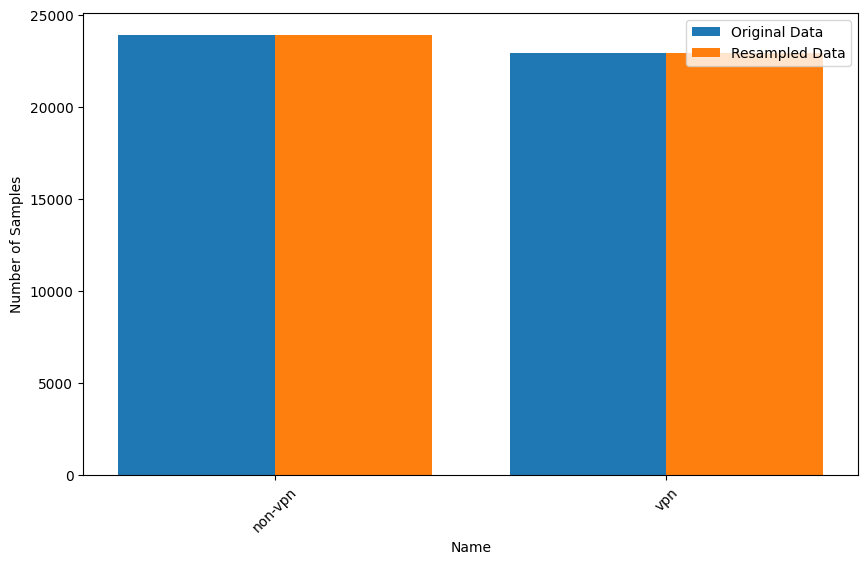

##### RESAMPLING WITH ADASYN DONE ######


In [17]:
print("##### START RESAMPLING WITH ADASYN ######")
data = pd.read_csv(f'{classified_folder}/bin_dataset.csv')
original_class_distribution = data['label_1'].value_counts()

data.fillna(0, inplace=True)
X = data.drop('label_1', axis=1)  # Tập dữ liệu đầu vào
y = data['label_1']  # Nhãn
adasyn = ADASYN(sampling_strategy='not majority', random_state=42,
                n_neighbors=200)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data = pd.concat(
    [resampled_data, pd.DataFrame(y_resampled, columns=['label_1'])], axis=1)
resampled_class_distribution = resampled_data['label_1'].value_counts()
balanced_file_path = os.path.join(
    classified_folder, "bin_dataset_balanced.csv")

combined_data = pd.concat([original_class_distribution, resampled_class_distribution], axis=1)
combined_data.columns = ['Original Data', 'Resampled Data']
combined_data = combined_data.sort_index()

class_labels_mapped = ["non-vpn", "vpn"]

plt.figure(figsize=(10, 6))
width = 0.4

plt.bar(range(len(class_labels_mapped)), combined_data['Original Data'], width=0.4, label='Original Data')
plt.bar([x + width for x in range(len(class_labels_mapped))], combined_data['Resampled Data'], width=0.4, label='Resampled Data')

plt.xlabel('Name')
plt.ylabel('Number of Samples')
plt.xticks([x + width/2 for x in range(len(class_labels_mapped))], class_labels_mapped, rotation=45)  # Set the x-ticks to be class names
plt.legend()
plt.show()

resampled_data.to_csv(balanced_file_path, index=False)
print("##### RESAMPLING WITH ADASYN DONE ######")

Preprocess 4. Fill các dữ liệu còn thiếu bằng 0

In [13]:
print("##### START ADDING ZEROS TO DATASET ######")
df = pd.read_csv(f'{classified_folder}/bin_dataset_balanced.csv')
img_shape = nearest_square(df.shape[1]) + 1
num_new_columns = img_shape - df.shape[1]

for i in range(1, num_new_columns + 1):
    new_col_name = f'zeros_{i}'
    df.insert(df.shape[1] - 1, new_col_name, 0)
df.to_csv(merged_file_path, index=False)
print("Dataset's shape", df.shape)
print("##### ADD ZEROS TO DATASET DONE ######")

##### START ADDING ZEROS TO DATASET ######
Dataset's shape (46829, 226)
##### ADD ZEROS TO DATASET DONE ######


Preprocess 5. Chuyển từng dòng dữ liệu thành Image

In [14]:
print("##### TRANSFERING DATA TO IMAGE ######")
df = pd.read_csv(f'{classified_folder}/bin_dataset.csv')
img_shape = nearest_square(df.shape[1]) + 1
data_img_shape = int(math.sqrt(img_shape-1))
for index, row in df.iterrows():
    data_row = df.iloc[index]
    label = data_row['label_1']
    data_row = data_row.drop('label_1')

    data_array = data_row.values.reshape(data_img_shape, data_img_shape)
    # Tạo hình ảnh từ mảng numpy
    image = Image.fromarray((data_array).astype('uint8'))

    output_folder = "non-vpn"
    if row["label_1"] == 1:
        output_folder = "vpn"

    output_folder_path = os.path.join(
        f'image_dataset/bin_dataset/{output_folder}')
    # Tạo đường dẫn đầy đủ đến thư mục đích -> lưu
    output_path = os.path.join(
        f'image_dataset/bin_dataset/{output_folder}', f'{index + 2}.png')

    # Kiểm tra nếu thư mục đích chưa tồn tại, thì tạo thư mục
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    image.save(output_path)
print("##### TRANSFER DATA TO IMAGE DONE ######")

##### TRANSFERING DATA TO IMAGE ######
##### TRANSFER DATA TO IMAGE DONE ######


MODEL TRAINING

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
from torchsummary import summary

Định nghĩa model

In [3]:
class CNNBinaryClassifier(nn.Module):
    def __init__(self):
        super(CNNBinaryClassifier, self).__init__()
        # Lớp tích chập 1
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp tích chập 2
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp kết nối đầy đủ
        self.fc1 = nn.Linear(32 * 3 * 3, 64)
        self.relu3 = nn.ReLU()

        self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(-1, 32 * 3 * 3)  # Flatten dữ liệu
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.dropout(x)

        x = self.fc2(x)
        x = self.sigmoid(x)  # Áp dụng hàm Sigmoid để đưa ra dự đoán nhị phân
        return x

model = CNNBinaryClassifier()

Chuẩn hóa dataset

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((15, 15)),  # Chuyển đổi kích thước thành 9x9
    transforms.Grayscale(),    # Chuyển đổi thành ảnh xám
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

Đọc dataset

In [5]:
dataset_root = "image_dataset/bin_dataset/"  # Thư mục gốc chứa dataset
train_dataset = datasets.ImageFolder(
    root=dataset_root, transform=data_transform)
print(train_dataset.classes)

['non-vpn', 'vpn']


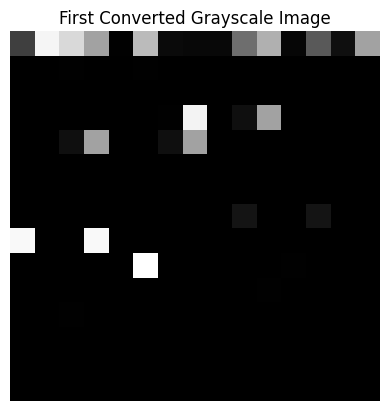

In [6]:
image_folder = "image_dataset/bin_dataset/vpn"
# Lấy danh sách các tệp hình ảnh trong thư mục
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

if image_files:
    # Lấy đường dẫn đến hình ảnh đầu tiên
    first_image_path = os.path.join(image_folder, image_files[1000])

    # Hiển thị hình ảnh đầu tiên
    img = plt.imread(first_image_path, format='PNG')
    plt.imshow(img, cmap=cm.gray)
    plt.title('First Converted Grayscale Image')
    plt.axis('off')  # Ẩn các trục
    plt.show()
else:
    print("No converted images found in the folder.")


In [7]:
# Chia Train/Validate/Test tỉ lệ 70 - 15 - 15
batch_size = 256  # Kích thước batch
total_samples = len(train_dataset)

train_size = int(0.7 * total_samples)
validate_size = int(0.15 * total_samples)
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    train_dataset, [train_size, validate_size, test_size])

# Tạo DataLoader sử dụng pin_memory để tăng hiệu suất nếu cần thiết
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)


Total 46829
Test Amount 7025
Train Amount 32780
Validation Amount 7024


In [4]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    current_gpu = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_gpu)
    print(f"Have {gpu_count} GPU available.")
    print(f"GPU's name: {gpu_name}")
else:
    print("No GPU available.")
print(torch.version.cuda)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Have 1 GPU available.
GPU's name: NVIDIA GeForce GTX 1050
11.7


In [5]:
model = CNNBinaryClassifier().to(device)
summary(model, (1, 15, 15))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 15, 15]             160
              ReLU-2           [-1, 16, 15, 15]               0
         MaxPool2d-3             [-1, 16, 7, 7]               0
            Conv2d-4             [-1, 32, 7, 7]           4,640
              ReLU-5             [-1, 32, 7, 7]               0
         MaxPool2d-6             [-1, 32, 3, 3]               0
            Linear-7                   [-1, 64]          18,496
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
          Sigmoid-11                    [-1, 1]               0
Total params: 23,361
Trainable params: 23,361
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [9]:
num_epochs = 300  # Số lượng epoch
learning_rate = 0.001

Train model

In [19]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
best_accuracy = 0.0  # Giá trị accuracy tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [20]:
if torch.cuda.is_available():
    # Chuyển mô hình và dữ liệu lên GPU
    model = model.to(device)
    # summary(model, (1, 32, 32))

    # Tạo hàm mất mát và tối ưu hóa trên GPU
    criterion = nn.BCELoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    if next(model.parameters()).is_cuda:
        print("Model is on GPU")
    else:
        print("Model is on CPU")

    # Quá trình huấn luyện
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
        train_loss = 0
        model.train()

        correct_predictions = 0
        total_samples = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output.squeeze(1), labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predicted = (output > 0.5).squeeze(1)
            correct_predictions += (predicted == labels.byte()).sum().item()
            total_samples += labels.size(0)

        train_accuracy = correct_predictions / total_samples
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(train_loss/len(train_loader))

        # Đánh giá trên tập validate
        validate_loss = 0
        validate_correct_predictions = 0
        validate_total_samples = 0

        model.eval()  # Chuyển sang chế độ đánh giá

        for i, (images, labels) in enumerate(validate_loader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # Không tính đạo hàm trong quá trình đánh giá
                output = model(images)
                loss = criterion(output.squeeze(1), labels.float())
                validate_loss += loss.item()

                predicted = (output > 0.5).squeeze(1)
                validate_correct_predictions += (predicted ==
                                                 labels.byte()).sum().item()
                validate_total_samples += labels.size(0)

        validate_accuracy = validate_correct_predictions / validate_total_samples
        validate_accuracy_list.append(validate_accuracy)
        validate_loss_list.append(validate_loss/len(validate_loader))

        print(
            f"Training loss={train_loss_list[-1]}, Training Accuracy={train_accuracy * 100:.2f}%, "
            f"Validation loss={validate_loss_list[-1]}, Validation Accuracy={validate_accuracy * 100:.2f}%")
        
        if validate_loss_list[-1] >= best_loss:
            no_improvement_count += 1
        else:
            best_loss = validate_loss_list[-1]
            no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Model is on GPU
Epoch 1/300: Training loss=0.6904810593109723, Training Accuracy=54.24%, Validation loss=0.6832622374807086, Validation Accuracy=70.32%
Epoch 2/300: Training loss=0.6765943627024806, Training Accuracy=68.32%, Validation loss=0.667764521070889, Validation Accuracy=85.31%
Epoch 3/300: Training loss=0.6545976372652276, Training Accuracy=75.44%, Validation loss=0.6370699235371181, Validation Accuracy=86.89%
Epoch 4/300: Training loss=0.6107024439545565, Training Accuracy=80.30%, Validation loss=0.5716474205255508, Validation Accuracy=88.62%
Epoch 5/300: Training loss=0.5234725560790808, Training Accuracy=84.06%, Validation loss=0.4499589481524059, Validation Accuracy=90.85%
Epoch 6/300: Training loss=0.3958449497703434, Training Accuracy=88.67%, Validation loss=0.3081836753657886, Validation Accuracy=92.78%
Epoch 7/300: Training loss=0.2821174749108248, Training Accuracy=92.10%, Validation loss=0.21809821469443186, Validation Accuracy=93.38%
Epoch 8/300: Training loss=0.221

Lưu model checkpoint

In [21]:
model_save_path = "GUI/models/bin_classification.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/bin_classification.pth


Load model checkpoint

In [10]:
model_save_path = "GUI/models/bin_classification.pth"
# Load lại model
model = CNNBinaryClassifier()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

Dự đoán trên tập test

In [11]:
model.eval()
test_accuracy_list = []
all_predictions = []
all_labels = []
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)

    predicted = (output > 0.5).squeeze(1)

    correct_predictions = (predicted == labels.byte()).sum().item()
    total_samples = labels.size(0)

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_predictions / total_samples
    test_accuracy_list.append(test_accuracy)

# Tính độ chính xác trung bình trên tập kiểm tra
average_test_accuracy = sum(test_accuracy_list) / len(test_accuracy_list)


Confusion matrix

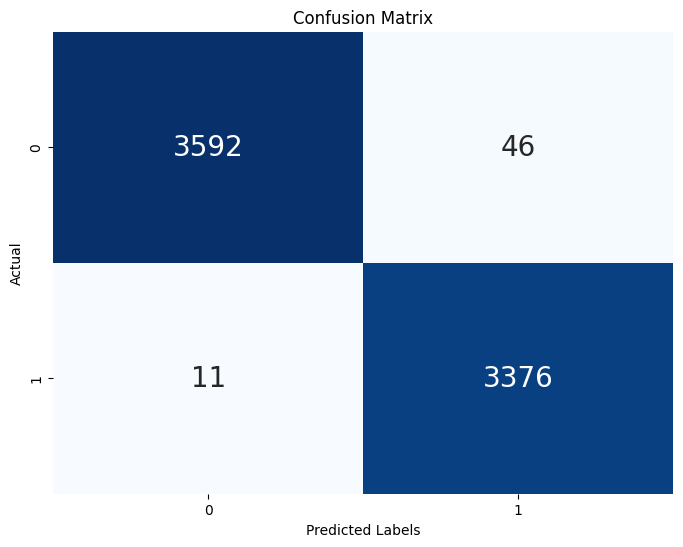

In [12]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
plt.xlabel('Predicted Labels')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Biểu diễn kết quả trên đồ thị

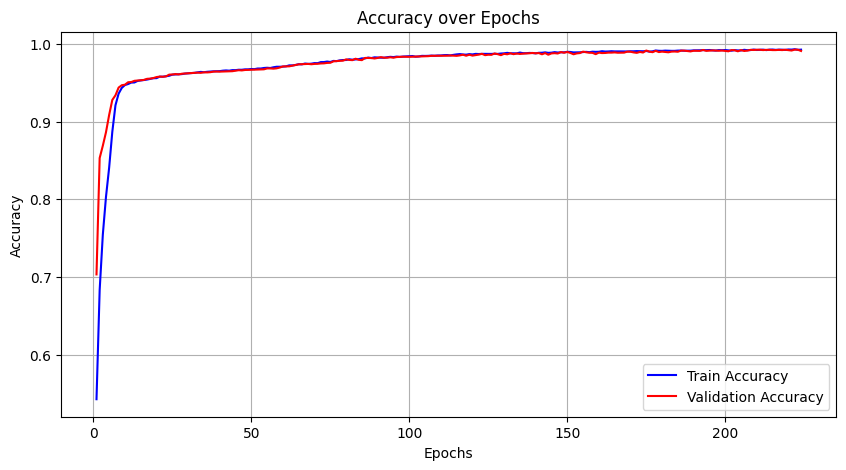

In [13]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

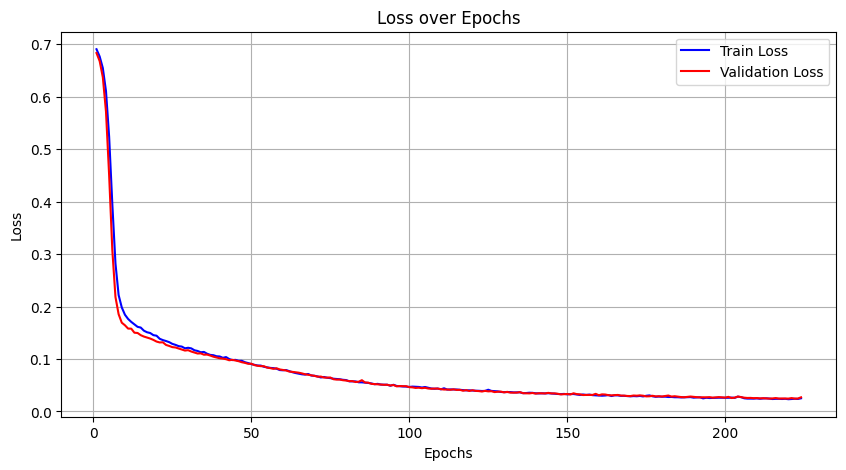

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Đánh giá theo các đại lượng

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import pandas as pd

In [16]:
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score", f1)
print(f"Average Test Accuracy: {average_test_accuracy * 100:.2f}%")

Precision:  0.9865575686732905
Recall:  0.9967522881606141
F1-score 0.9916287266852695
Average Test Accuracy: 99.20%


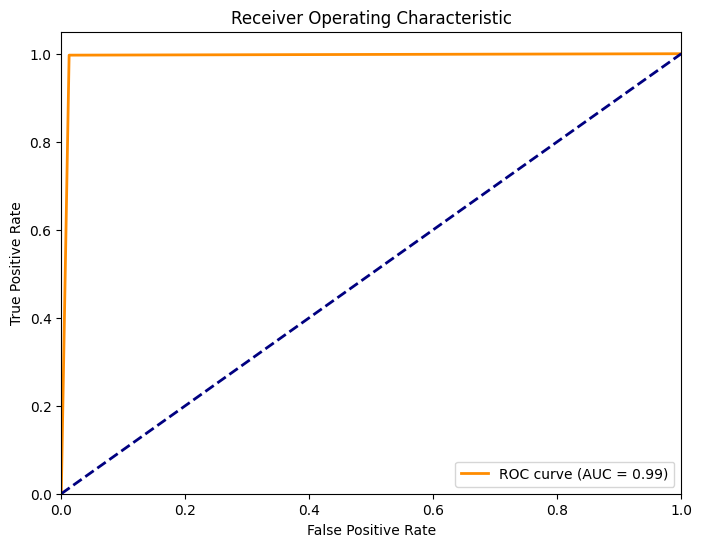

In [17]:
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Transfer Learning

In [2]:
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch.utils.data import random_split
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.Grayscale(num_output_channels=3), # Chuyển đổi thành ảnh xám, 3 kênh màu xám
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

In [4]:
dataset_root = "image_dataset/bin_dataset/"  # Thư mục gốc chứa dataset
train_dataset = ImageFolder(
    root=dataset_root, transform=data_transform)
print(train_dataset.classes)

['non-vpn', 'vpn']


In [5]:
batch_size = 512  # Kích thước batch
total_samples = len(train_dataset)

train_size = int(0.7 * total_samples)
validate_size = int(0.15 * total_samples)
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    train_dataset, [train_size, validate_size, test_size])

# Tạo DataLoader sử dụng pin_memory để tăng hiệu suất nếu cần thiết
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Total 46829
Test Amount 7025
Train Amount 32780
Validation Amount 7024


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


ResNet50

In [8]:
resnet50 = models.resnet50(pretrained=True)
# Fine tuning
for param in resnet50.parameters():
    param.requires_grad = False

fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, 2), 
    nn.LogSoftmax(dim=1)
)
num_classes = 2
# resnet50.fc = nn.Linear(2048, num_classes)

In [8]:
learning_rate = 0.0001
num_epochs = 200
weight_decay = 0.001

In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        resnet50.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [56]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [57]:
resnet50.to(device)
for epoch in range(num_epochs):
    resnet50.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    resnet50.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 0.5304, Train Accuracy: 72.37%, Validation Loss: 0.5694, Validation Accuracy: 67.54%
Epoch 2/200, Train Loss: 0.4100, Train Accuracy: 81.37%, Validation Loss: 0.3532, Validation Accuracy: 84.33%
Epoch 3/200, Train Loss: 0.3641, Train Accuracy: 84.08%, Validation Loss: 0.3216, Validation Accuracy: 85.89%
Epoch 4/200, Train Loss: 0.3350, Train Accuracy: 85.82%, Validation Loss: 0.3011, Validation Accuracy: 87.30%
Epoch 5/200, Train Loss: 0.3196, Train Accuracy: 86.69%, Validation Loss: 0.2851, Validation Accuracy: 88.03%
Epoch 6/200, Train Loss: 0.3032, Train Accuracy: 87.36%, Validation Loss: 0.2750, Validation Accuracy: 88.74%
Epoch 7/200, Train Loss: 0.2911, Train Accuracy: 87.89%, Validation Loss: 0.2627, Validation Accuracy: 89.25%
Epoch 8/200, Train Loss: 0.2806, Train Accuracy: 88.53%, Validation Loss: 0.2524, Validation Accuracy: 89.68%
Epoch 9/200, Train Loss: 0.2715, Train Accuracy: 88.94%, Validation Loss: 0.2514, Validation Accuracy: 89.96%
Epoch 10/2

In [58]:
model_save_path = "GUI/models/bin_classification_resnet50.pth"
torch.save({
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/bin_classification_resnet50.pth


In [10]:
model_save_path = "GUI/models/bin_classification_resnet50.pth"
resnet50 = models.resnet50(pretrained=True)
# Fine tuning
for param in resnet50.parameters():
    param.requires_grad = False

num_classes = 2
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes), 
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
resnet50.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [11]:
resnet50 = resnet50.to(device)
resnet50.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = resnet50(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.9665480427046264


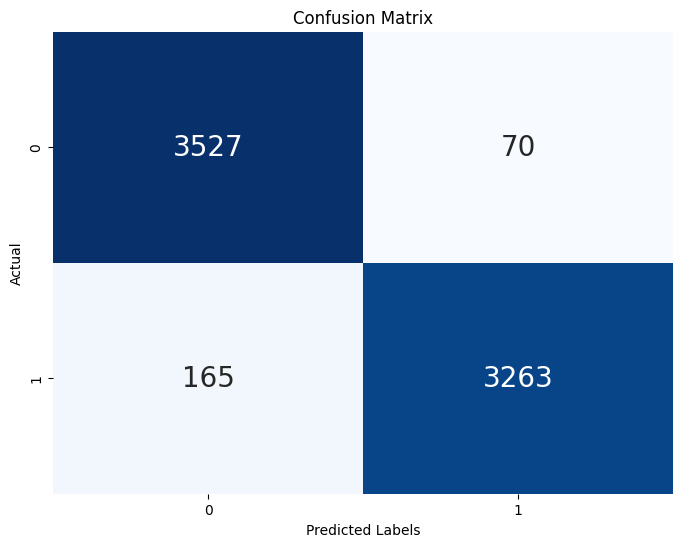

In [12]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
plt.xlabel('Predicted Labels')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

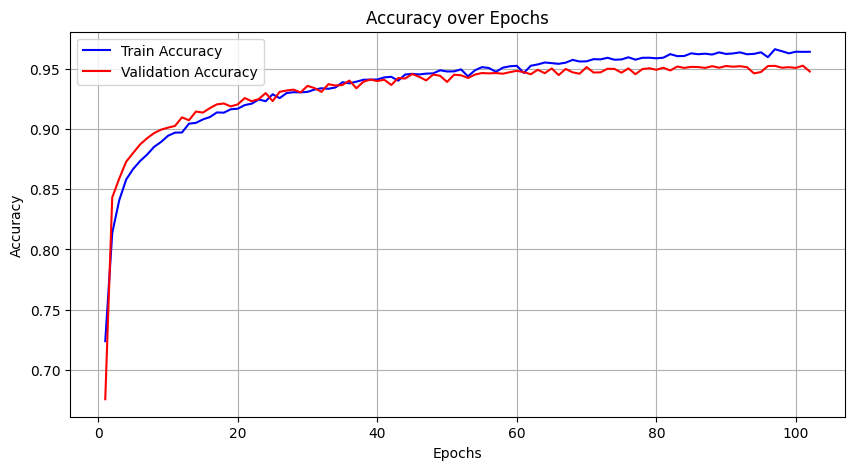

In [13]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

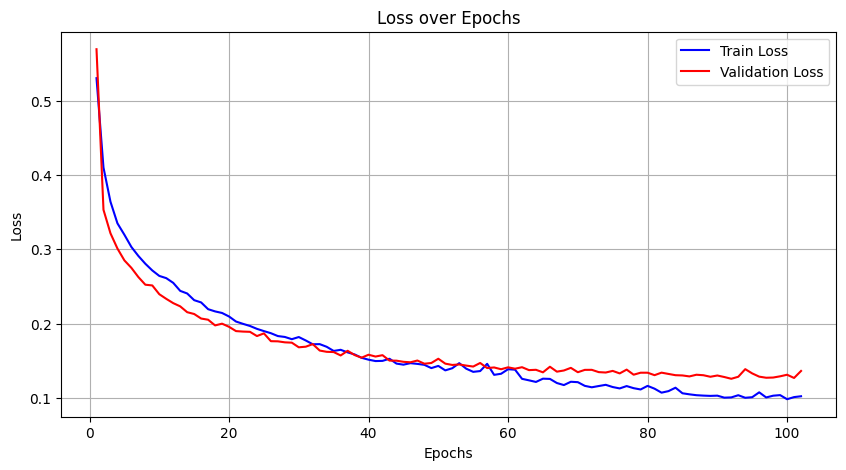

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score", f1)
print(f"Average Test Accuracy: {predict_accuracy * 100:.2f}%")

Precision:  0.978997899789979
Recall:  0.9518669778296382
F1-score 0.9652418281319332
Average Test Accuracy: 96.65%


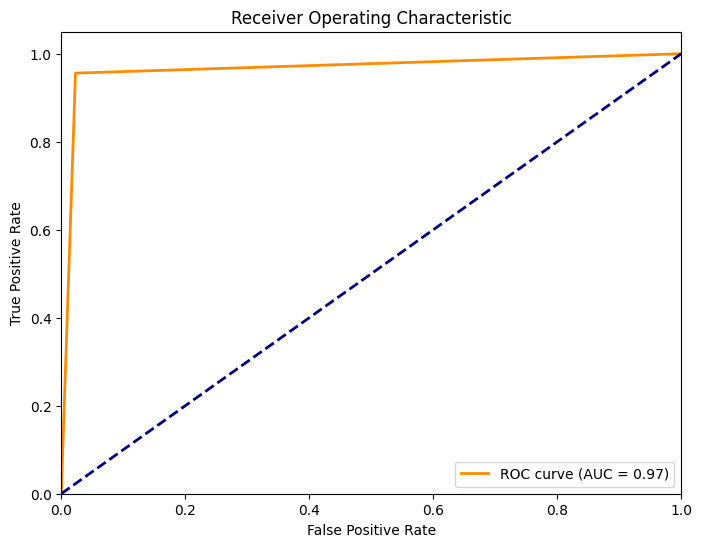

In [20]:
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

AlexNet

In [61]:
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 2
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes),
    nn.LogSoftmax(dim=1)
)

c:\Users\ltpg2\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
learning_rate = 0.0001
num_epochs = 200
weight_decay = 0.001

In [63]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        alexnet.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [64]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [65]:
alexnet.to(device)
for epoch in range(num_epochs):
    alexnet.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    alexnet.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')


    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 0.4764, Train Accuracy: 77.44%, Validation Loss: 0.3797, Validation Accuracy: 82.76%
Epoch 2/200, Train Loss: 0.3902, Train Accuracy: 82.52%, Validation Loss: 0.3125, Validation Accuracy: 86.99%
Epoch 3/200, Train Loss: 0.3418, Train Accuracy: 84.83%, Validation Loss: 0.3192, Validation Accuracy: 86.65%
Epoch 4/200, Train Loss: 0.3095, Train Accuracy: 86.51%, Validation Loss: 0.2268, Validation Accuracy: 90.05%
Epoch 5/200, Train Loss: 0.2923, Train Accuracy: 87.13%, Validation Loss: 0.2520, Validation Accuracy: 89.24%
Epoch 6/200, Train Loss: 0.2865, Train Accuracy: 87.26%, Validation Loss: 0.1975, Validation Accuracy: 91.33%
Epoch 7/200, Train Loss: 0.2725, Train Accuracy: 87.97%, Validation Loss: 0.1910, Validation Accuracy: 91.64%
Epoch 8/200, Train Loss: 0.2673, Train Accuracy: 88.12%, Validation Loss: 0.1888, Validation Accuracy: 91.76%
Epoch 9/200, Train Loss: 0.2516, Train Accuracy: 88.98%, Validation Loss: 0.2123, Validation Accuracy: 90.46%
Epoch 10/2

In [66]:
model_save_path = "GUI/models/bin_classification_alexnet.pth"
torch.save({
    'model_state_dict': alexnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/bin_classification_alexnet.pth


In [17]:
model_save_path = "GUI/models/bin_classification_alexnet.pth"
num_classes = 2
# Load lại model
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 2
# alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
alexnet.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [18]:
alexnet = alexnet.to(device)
alexnet.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = alexnet(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.9661209964412811


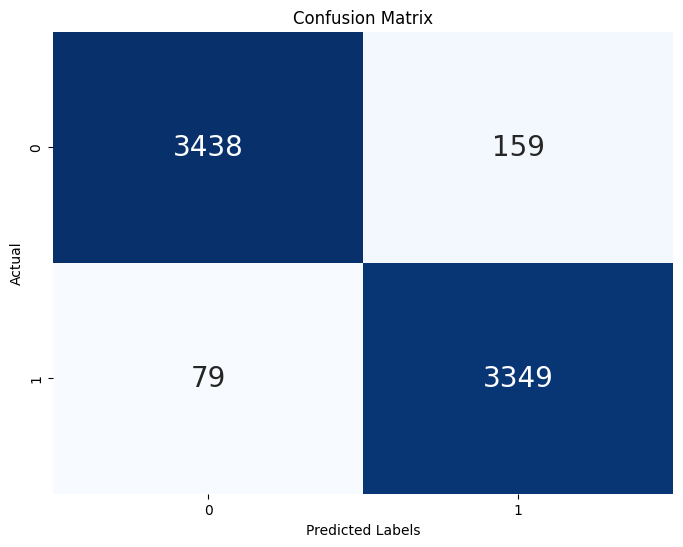

In [19]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
plt.xlabel('Predicted Labels')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

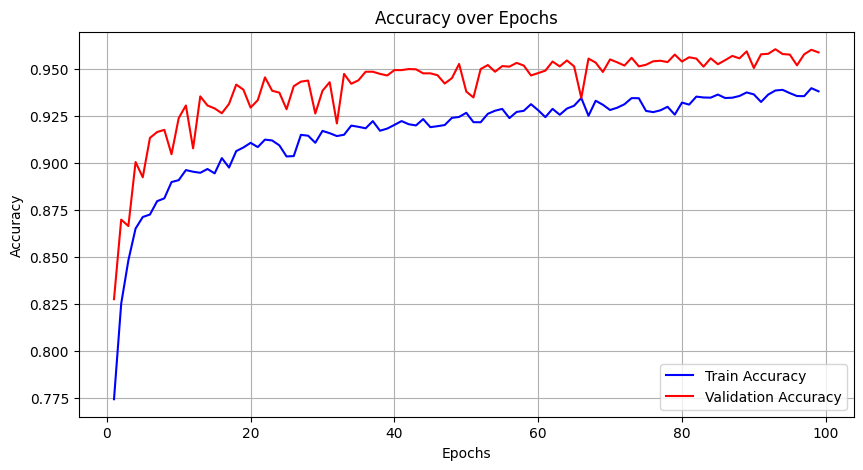

In [27]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

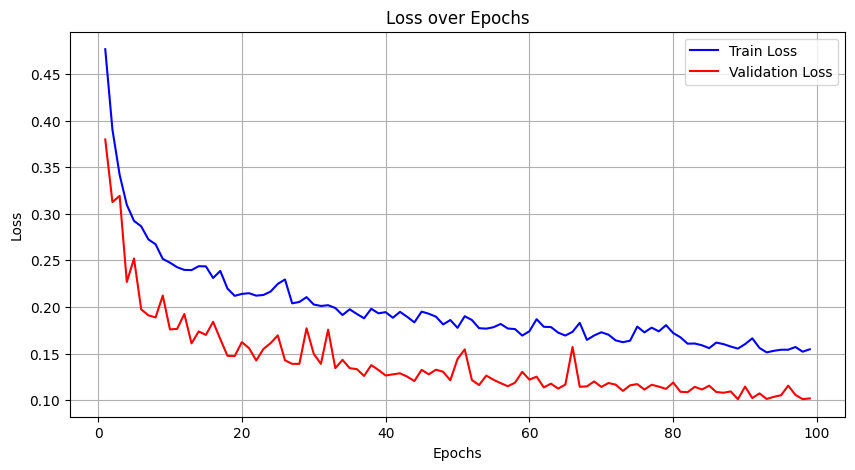

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score", f1)
print(f"Average Test Accuracy: {predict_accuracy * 100:.2f}%")

Precision:  0.9546750285062714
Recall:  0.9769544924154026
F1-score 0.9656862745098039
Average Test Accuracy: 96.61%


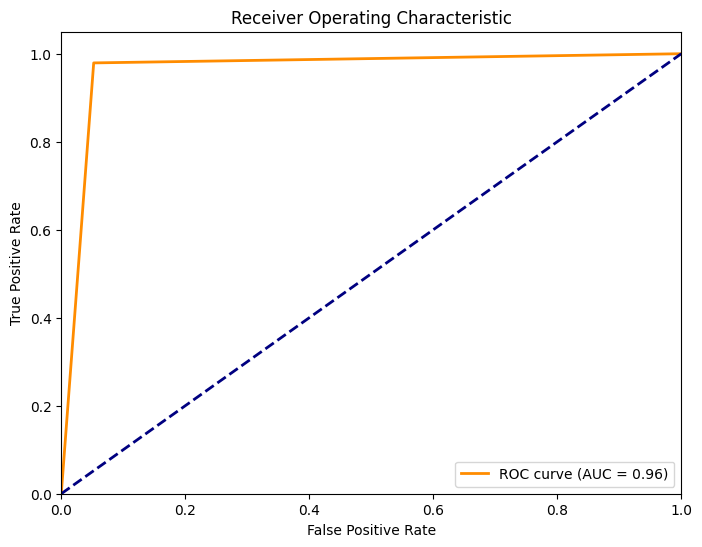

In [30]:
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

VGG-16

In [50]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 2
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes),
    nn.LogSoftmax(dim=1)
)

In [51]:
learning_rate = 0.0001
num_epochs = 200
weight_decay = 0.0001

In [52]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        vgg16.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [53]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [54]:
vgg16.to(device)
for epoch in range(num_epochs):
    vgg16.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    vgg16.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 0.2497, Train Accuracy: 89.74%, Validation Loss: 0.1364, Validation Accuracy: 94.86%
Epoch 2/200, Train Loss: 0.1303, Train Accuracy: 95.09%, Validation Loss: 0.0989, Validation Accuracy: 96.27%
Epoch 3/200, Train Loss: 0.1078, Train Accuracy: 96.19%, Validation Loss: 0.1023, Validation Accuracy: 96.94%
Epoch 4/200, Train Loss: 0.0959, Train Accuracy: 96.42%, Validation Loss: 0.0809, Validation Accuracy: 97.17%
Epoch 5/200, Train Loss: 0.0793, Train Accuracy: 97.12%, Validation Loss: 0.0864, Validation Accuracy: 96.85%
Epoch 6/200, Train Loss: 0.0692, Train Accuracy: 97.58%, Validation Loss: 0.0923, Validation Accuracy: 96.71%
Epoch 7/200, Train Loss: 0.0724, Train Accuracy: 97.35%, Validation Loss: 0.0667, Validation Accuracy: 97.78%
Epoch 8/200, Train Loss: 0.0621, Train Accuracy: 97.87%, Validation Loss: 0.1062, Validation Accuracy: 96.14%
Epoch 9/200, Train Loss: 0.0651, Train Accuracy: 97.67%, Validation Loss: 0.0718, Validation Accuracy: 97.31%
Epoch 10/2

In [17]:
model_save_path = "GUI/models/bin_classification_vgg16.pth"
torch.save({
    'model_state_dict': vgg16.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/bin_classification_vgg16.pth


In [22]:
model_save_path = "GUI/models/bin_classification_vgg16.pth"
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 2
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
vgg16.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [24]:
vgg16 = vgg16.to(device)
vgg16.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = vgg16(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.9928825622775801


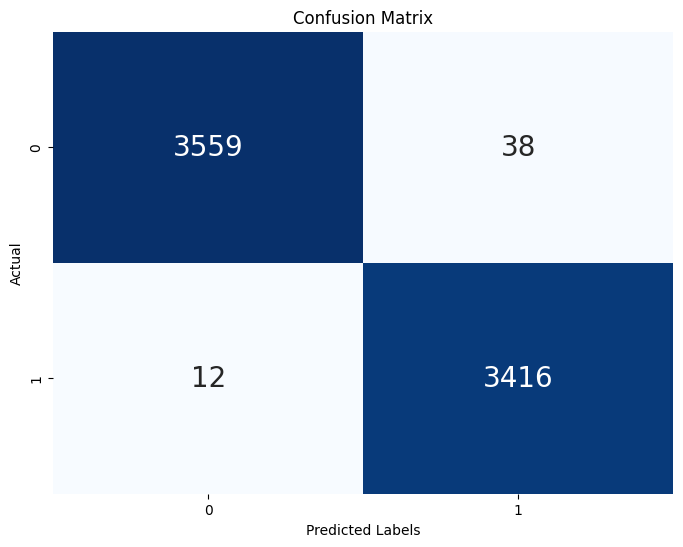

In [26]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
plt.xlabel('Predicted Labels')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

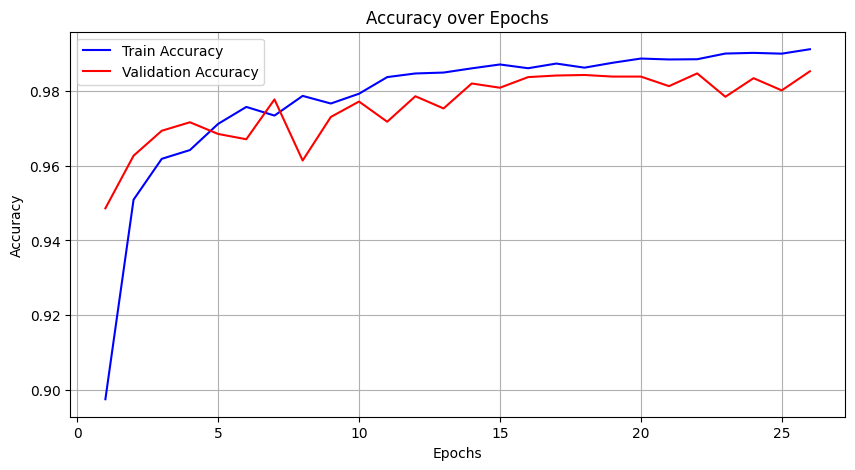

In [35]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

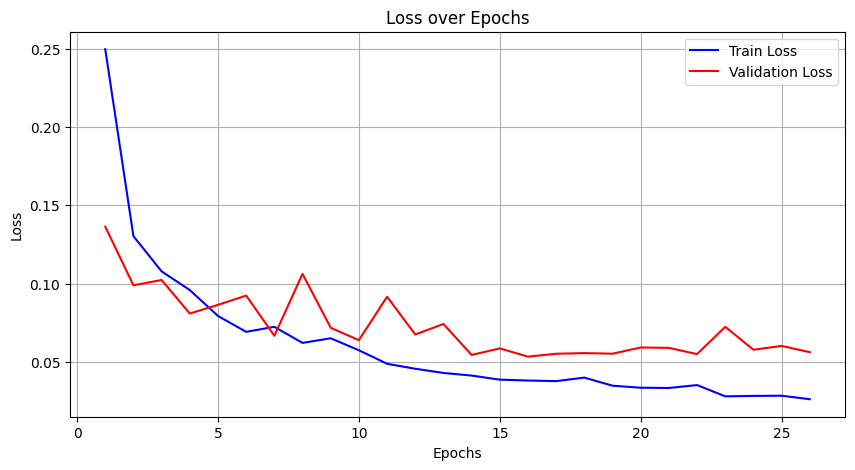

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score", f1)
print(f"Average Test Accuracy: {predict_accuracy * 100:.2f}%")

Precision:  0.9889982628836133
Recall:  0.9964994165694282
F1-score 0.9927346701540251
Average Test Accuracy: 99.29%


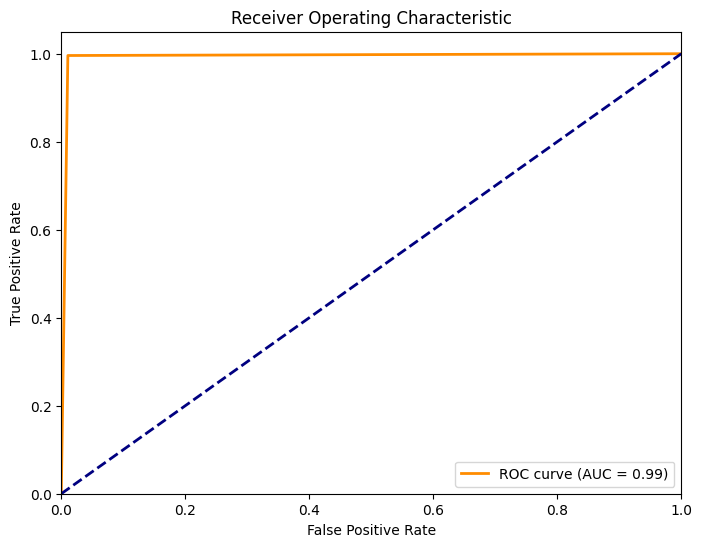

In [38]:
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

DenseNet-121

In [69]:
densenet121 = models.densenet121(pretrained=True)

for param in densenet121.features.parameters():
    param.requires_grad = False

in_features = densenet121.classifier.in_features
num_classes = 2
densenet121.classifier = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes),
    nn.LogSoftmax(dim=1)
)
densenet121.fc = nn.Linear(1024, num_classes)

c:\Users\ltpg2\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
learning_rate = 0.0001
num_epochs = 200
weight_decay = 0.0001

In [71]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        densenet121.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [72]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [73]:
densenet121.to(device)
for epoch in range(num_epochs):
    densenet121.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = densenet121(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    densenet121.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = densenet121(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 0.6057, Train Accuracy: 67.40%, Validation Loss: 0.4904, Validation Accuracy: 80.71%
Epoch 2/200, Train Loss: 0.4334, Train Accuracy: 80.90%, Validation Loss: 0.3505, Validation Accuracy: 85.91%
Epoch 3/200, Train Loss: 0.3610, Train Accuracy: 84.82%, Validation Loss: 0.3037, Validation Accuracy: 87.49%
Epoch 4/200, Train Loss: 0.3216, Train Accuracy: 86.30%, Validation Loss: 0.2731, Validation Accuracy: 88.64%
Epoch 5/200, Train Loss: 0.3043, Train Accuracy: 87.56%, Validation Loss: 0.2535, Validation Accuracy: 89.19%
Epoch 6/200, Train Loss: 0.2783, Train Accuracy: 88.18%, Validation Loss: 0.2433, Validation Accuracy: 89.75%
Epoch 7/200, Train Loss: 0.2686, Train Accuracy: 88.61%, Validation Loss: 0.2321, Validation Accuracy: 90.08%
Epoch 8/200, Train Loss: 0.2535, Train Accuracy: 89.06%, Validation Loss: 0.2233, Validation Accuracy: 90.46%
Epoch 9/200, Train Loss: 0.2483, Train Accuracy: 89.63%, Validation Loss: 0.2156, Validation Accuracy: 90.75%
Epoch 10/2

In [74]:
model_save_path = "GUI/models/bin_classification_densenet121.pth"
torch.save({
    'model_state_dict': densenet121.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/bin_classification_densenet121.pth


In [10]:
model_save_path = "GUI/models/bin_classification_densenet121.pth"
densenet121 = models.densenet121(pretrained=True)

for param in densenet121.features.parameters():
    param.requires_grad = False

in_features = densenet121.classifier.in_features
num_classes = 2
densenet121.classifier = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes),
    nn.LogSoftmax(dim=1)
)
densenet121.fc = nn.Linear(1024, num_classes)

checkpoint = torch.load(model_save_path)
densenet121.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [11]:
densenet121 = densenet121.to(device)
densenet121.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = densenet121(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.975373665480427


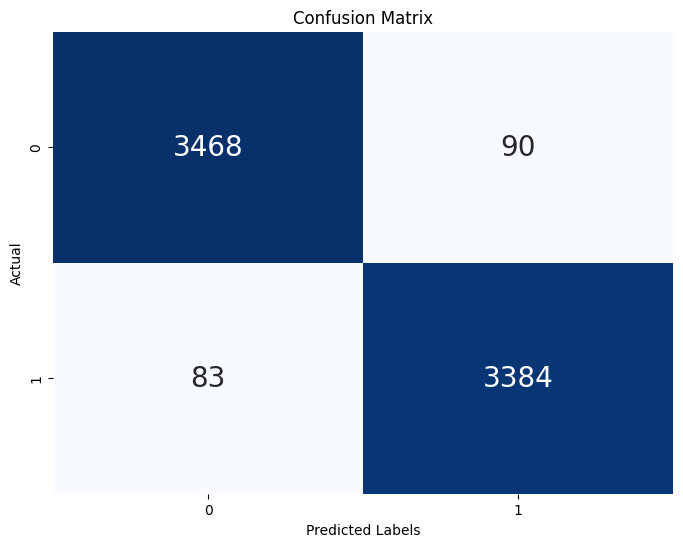

In [13]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
plt.xlabel('Predicted Labels')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

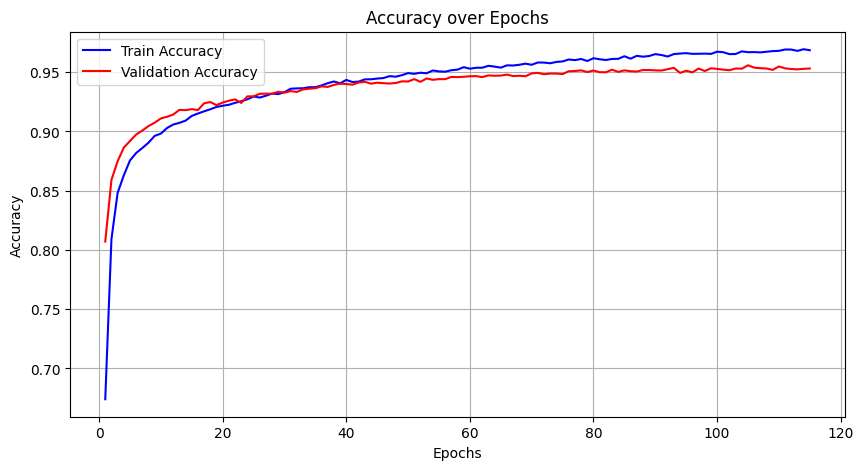

In [43]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

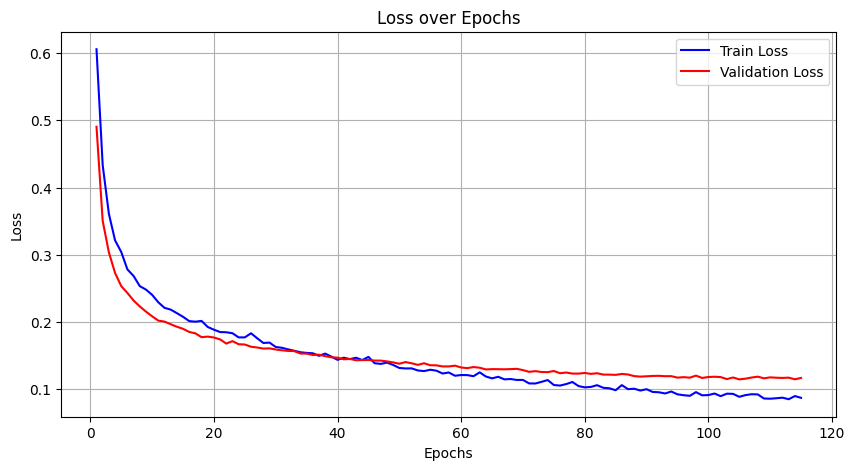

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score", f1)
print(f"Average Test Accuracy: {predict_accuracy * 100:.2f}%")

Precision:  0.9740932642487047
Recall:  0.976059994231324
F1-score 0.975075637516208
Average Test Accuracy: 97.54%


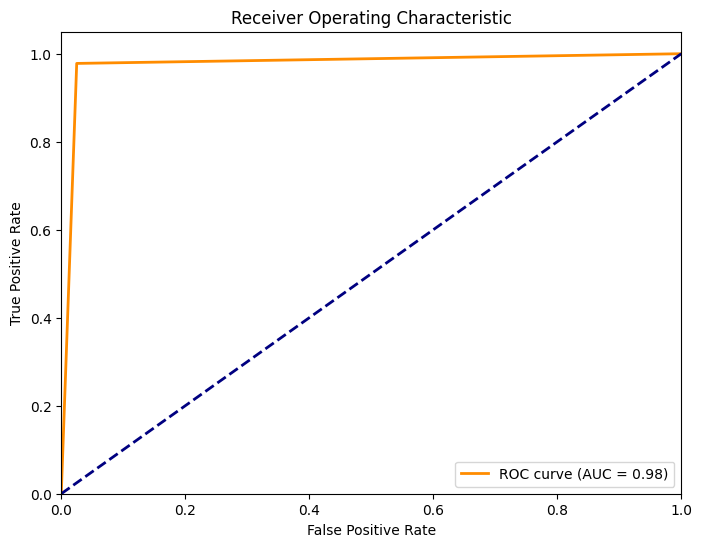

In [46]:
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()